# This script demonstrates the use of multiple classifiers for (restricted) mnist number sequences in Tensorflow on an extremly simple CNN


## We import:
<ol>
    <li> keras for getting the mnist data</li>
    <li> to_categorical to encode the labels to One Hot format </li>
    <li> tensorflow </li>
    <li> numpy for creating the number sequences </li>
    <li> os </li>
    <li> matplotlib </li>
        

In [3]:
from keras.datasets import mnist
from keras.utils import to_categorical

import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt


## We want to read in sequences of numbers. In order to achieve this we horizontally concat number up to sequence length 5

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

def concat_images(data, label, number_of_images):
    images = []
    labels = []
    
    for i in range(number_of_images):
        #First get a random number between 1 and 5 to indicate how long the seq will be
        seq_len = np.random.randint(1, 6)
        # Then get seq_len images and concat them to one sequence
        rnd_ind = np.random.randint(0, len(data), seq_len)
        #Create a new concatted image
        image = data[rnd_ind[0]]
        temp_label = label[rnd_ind[0]]
        
        #Stack the images and labels
        for i in rnd_ind[1:]:
            image = np.hstack((image, data[i]))
            temp_label = np.vstack((temp_label, label[i]))
        
        # pad the image with zeros so all have the same size
        image = np.pad(image, [(0,0),(0,140-image.shape[1])], 'constant')
        #Pad labels with 10 as a NAN indicator
        label_padded = np.pad(label[rnd_ind], [(0), (5-len(rnd_ind))], 'constant', constant_values = 10)
                
        labels.append(label_padded)
        images.append(image)
        
    
    return np.array(images), np.array(labels)

train_data, train_labels = concat_images(X_train, y_train, 100000)
test_data, test_labels = concat_images(X_test, y_test, 32000)

## Preprocess the data (reshape to correct format for grayscale + standartization). Create one Hot-Hot Encodings

In [5]:
train_data_preprocessed = train_data.reshape(train_data.shape[0], train_data.shape[1], train_data.shape[2],1)
test_data_preprocessed = test_data.reshape(test_data.shape[0], test_data.shape[1], test_data.shape[2],1)

#Standartize data
train_data_preprocessed = train_data_preprocessed / 255
test_data_preprocessed = test_data_preprocessed / 255

#OHE labels

train_labels_OHE = to_categorical(train_labels,11)
test_labels_OHE = to_categorical(test_labels,11)

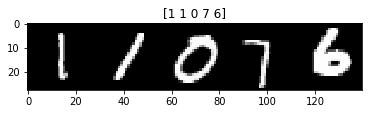

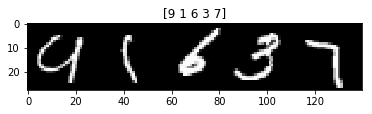

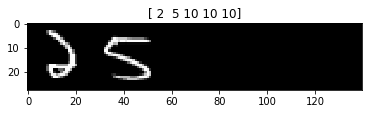

<Figure size 432x288 with 0 Axes>

In [6]:
#Look at some sample data with labels
plt.figure(0)

for i in range(3):
    plt.imshow(train_data_preprocessed[i].reshape(28,140), cmap="gray")
    plt.title(train_labels[i])
    plt.figure(i+1)

## Define accuracy function for evaluation and next_batch function for training

In [7]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 2) == labels)
            / predictions.shape[1] / predictions.shape[0])

def next_batch(data, label, batch_size):
    rnd_ind = np.random.randint(0, len(data), batch_size)
    return data[rnd_ind], label[rnd_ind]

# Create the model
# 2 Convolutions followed by MaxPooling 
# 1024 unit Dense layer followed by softmax

### To keep it simple there is no visualization nor storing of the model and its parameters

In [8]:
#Create a model with 5 classifiers

graph = tf.Graph()

with graph.as_default():
    data = tf.placeholder(dtype=tf.float32,shape=(None, 28,140,1))
    labels = tf.placeholder(dtype=tf.float32, shape=(None, 5, 11))
    
    w1 = tf.Variable(tf.truncated_normal(shape=(3,3, 1,32), stddev=0.1))
    b1 = tf.Variable(tf.zeros(32))
    
    w2 = tf.Variable(tf.truncated_normal(shape=(3,3,32,64), stddev=0.1))
    b2 = tf.Variable(tf.constant(1., shape=[64]))
    
    w3 = tf.Variable(tf.truncated_normal(shape=(28 // 4 * 140 // 4 * 64, 1024)))
    b3 = tf.Variable(tf.constant(1., shape=[1024]))
    
    w4 = tf.Variable(tf.truncated_normal(shape=(1024,11)))
    b4 = tf.Variable(tf.constant(1., shape=[11]))
    
    w5 = tf.Variable(tf.truncated_normal(shape=(1024,11)))
    b5 = tf.Variable(tf.constant(1., shape=[11]))

    w6 = tf.Variable(tf.truncated_normal(shape=(1024,11)))
    b6 = tf.Variable(tf.constant(1., shape=[11]))
    
    w7 = tf.Variable(tf.truncated_normal(shape=(1024,11)))
    b7 = tf.Variable(tf.constant(1., shape=[11]))
    
    w8 = tf.Variable(tf.truncated_normal(shape=(1024,11)))
    b8 = tf.Variable(tf.constant(1., shape=[11]))
    

    
    def model(x, w, b):
        conv= tf.nn.relu(tf.nn.conv2d(x, w1, [1,1,1,1], padding="SAME")+b1)
        conv = tf.nn.max_pool(conv, [1,2,2,1], [1,2,2,1], padding="SAME")
        conv = tf.nn.relu(tf.nn.conv2d(conv, w2, [1,1,1,1], padding="SAME")+b2)
        conv = tf.nn.max_pool(conv, [1,2,2,1], [1,2,2,1],padding="SAME")
        shape = conv.get_shape().as_list()
        reshape = tf.reshape(conv, [-1, shape[1] * shape[2] * shape[3]])
        dense = tf.nn.relu(tf.matmul(reshape, w3)+b3)
        return tf.matmul(dense, w) + b
    
    pred = []
    pred.append(model(data, w4, b4))
    pred.append(model(data, w5, b5))
    pred.append(model(data, w6, b6))
    pred.append(model(data, w7, b7))
    pred.append(model(data, w8,b8))
    pred = tf.stack(pred, axis=1)
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=labels))
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)
    prediction = tf.nn.softmax(pred)
    
    init = tf.global_variables_initializer()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [11]:
sess = tf.Session(graph=graph)    
sess.run(init)


for step in range(30000):
        
        data_batch, label_batch = next_batch(train_data_preprocessed, train_labels_OHE, 24)
        _,actual_loss = sess.run([optimizer, loss], feed_dict={data : data_batch, labels : label_batch})
        
        if step % 1000 == 0:
            print("Step {}, Loss {}".format(step, actual_loss))
            train_eval = sess.run(prediction,feed_dict = {data : train_data_preprocessed[:2048]})
            print("Train ACC: {}".format(accuracy(train_eval, train_labels[:2048])))
            test_eval = sess.run(prediction, feed_dict = {data : test_data_preprocessed[:1024]})
            print("Test Acc: {}".format(accuracy(test_eval, test_labels[:1024])))

Step 0, Loss 3669.671142578125
Train ACC: 21.953125
Test Acc: 22.55859375
Step 1000, Loss 36.23963165283203
Train ACC: 61.923828125
Test Acc: 63.7890625
Step 2000, Loss 10.60263442993164
Train ACC: 67.01171875
Test Acc: 69.00390625
Step 3000, Loss 9.9264497756958
Train ACC: 73.388671875
Test Acc: 75.48828125
Step 4000, Loss 3.3237369060516357
Train ACC: 78.876953125
Test Acc: 81.3671875
Step 5000, Loss 4.936378002166748
Train ACC: 87.685546875
Test Acc: 89.55078125
Step 6000, Loss 0.38899168372154236
Train ACC: 89.794921875
Test Acc: 90.76171875
Step 7000, Loss 2.339449405670166
Train ACC: 92.255859375
Test Acc: 92.59765625
Step 8000, Loss 2.0763306617736816
Train ACC: 93.1640625
Test Acc: 93.90625
Step 9000, Loss 4.270471096038818
Train ACC: 95.234375
Test Acc: 95.52734375
Step 10000, Loss 0.5125005841255188
Train ACC: 95.615234375
Test Acc: 95.72265625
Step 11000, Loss 0.5427903532981873
Train ACC: 96.2109375
Test Acc: 96.40625
Step 12000, Loss 0.43468329310417175
Train ACC: 95.98632

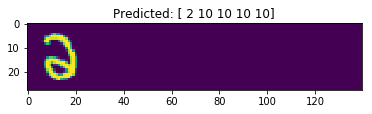

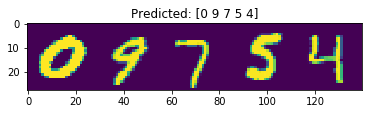

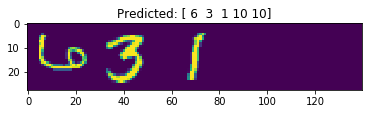

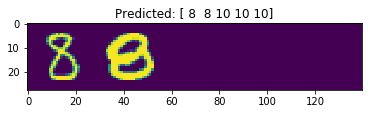

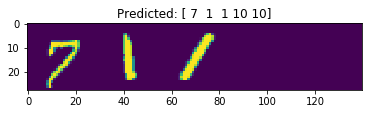

In [21]:
rnd_ind = np.random.randint(0, len(test_data_preprocessed), 5)
show_images = test_data_preprocessed[rnd_ind]

pred = sess.run(prediction, feed_dict={data : show_images})

for it,img in enumerate(show_images):
    plt.figure()
    plt.imshow(img.reshape(28,140))
    plt.title("Predicted: %s"%(pred[it].argmax(1)))

# This gives about 98 test accuracy. There is of course lots of space to the top by improving the network structure and adding Regularization and Batch Norm. In order to achieve a more dynamic structure one might switch to a RNN